In [21]:
import bioread
import numpy as np
import pandas as pd
import heartpy as hp
import neurokit2 as nk
import os 

df_list = []
channels_to_extract = ['ECG - ECG100C', 'C5 - Expression' ]
directory_path = r'C:\Users\User\Desktop\NPU_FILES'

for filename in os.listdir(directory_path):
    if filename.endswith(".acq"):
        file_path= os.path.join(directory_path, filename)
        acq_file = bioread.read_file(file_path)
        data = {}
        for channel_name in channels_to_extract:
            channel = acq_file.named_channels[channel_name]
            data[channel_name] = channel.data

        df = pd.DataFrame(data)
        df_list.append(df)
for i, df in enumerate(df_list):
    print(f"DataFrame for file {i}:\n", df)


DataFrame for file 0:
          ECG - ECG100C  C5 - Expression
0             0.037079             47.0
1             0.038147             47.0
2             0.039368             47.0
3             0.040283             47.0
4             0.040741             47.0
...                ...              ...
6154508       0.068665             47.0
6154509       0.067291             47.0
6154510       0.065308             47.0
6154511       0.063629             47.0
6154512       0.061798             47.0

[6154513 rows x 2 columns]
DataFrame for file 1:
          ECG - ECG100C  C5 - Expression
0             0.001373              0.0
1             0.001068              0.0
2             0.000763              0.0
3             0.000610              0.0
4             0.000305              0.0
...                ...              ...
6649582       0.017700              0.0
6649583       0.015564              0.0
6649584       0.013275              0.0
6649585       0.010681              0.0
664958

In [22]:
for df in df_list:
    df = df.dropna()
    df = df.reset_index(drop=True)


In [25]:

for i, df in enumerate(df_list):
    non_zero_indices = df.index[df['C5 - Expression'] != 0]
    index_rows_to_change = []
    for j in range(len(non_zero_indices) - 1):
        if non_zero_indices[j + 1] == non_zero_indices[j] + 1:
            index_rows_to_change.append(non_zero_indices[j])
    modified_df = df.copy()  # Create a copy of the DataFrame
    for index in index_rows_to_change:
        modified_df.loc[index, 'C5 - Expression'] = 0
    # Update the DataFrame in df_list with the modified one
    df_list[i] = modified_df

In [26]:
baseline_row_numbers = []  

for df in df_list:
    baseline_rows = df.index[df['C5 - Expression'] == 99].tolist()
    baseline_row_numbers.append(baseline_rows)

for i, baseline_rows in enumerate(baseline_row_numbers):
    print(f"Baseline rows for DataFrame {i}: {baseline_rows}\n")

Baseline rows for DataFrame 0: []

Baseline rows for DataFrame 1: [2511643, 5243759, 5478683, 5700043, 6187678]

Baseline rows for DataFrame 2: [6121595]

Baseline rows for DataFrame 3: [643262, 3081683]

Baseline rows for DataFrame 4: [151909, 2592344]


In [29]:

baseline_minutes = []

for df, baseline_rows in zip(df_list, baseline_row_numbers):
    temp = []

    for row in baseline_rows:
        calc_minute = df.iloc[row:row + (2000 * 60)]
        temp.append(calc_minute)

    if temp:
    # Concatenate  into a single DataFrame
        baseline_minute = pd.concat(temp)
        baseline_minute = baseline_minute[['ECG - ECG100C']]
        baseline_minutes.append(baseline_minute)

# Print the extended DataFrames
for i, extended_df in enumerate(baseline_minutes):
    print(f"Extended DataFrame {i}:\n{baseline_minutes}\n")

Extended DataFrame 0:
[         ECG - ECG100C
2511643      -0.014801
2511644      -0.014343
2511645      -0.014801
2511646      -0.014496
2511647      -0.014496
...                ...
6307673      -0.034790
6307674      -0.035248
6307675      -0.036163
6307676      -0.037231
6307677      -0.038147

[600000 rows x 1 columns],          ECG - ECG100C
6121595       0.000153
6121596       0.000458
6121597       0.000763
6121598       0.000763
6121599       0.000916
...                ...
6241590      -0.206909
6241591      -0.203857
6241592      -0.201111
6241593      -0.198212
6241594      -0.195007

[120000 rows x 1 columns],          ECG - ECG100C
643262       -0.010986
643263       -0.011139
643264       -0.011444
643265       -0.011597
643266       -0.011597
...                ...
3201678      -0.028229
3201679      -0.028381
3201680      -0.029297
3201681      -0.030212
3201682      -0.030670

[240000 rows x 1 columns],          ECG - ECG100C
151909       -0.070496
151910       -0.071

In [30]:
all_baseline_arrays = []
for df in baseline_minutes:
    baseline_minute_array = df['ECG - ECG100C'].values.flatten()
    all_baseline_arrays.append(baseline_minute_array)


In [31]:
mean_heart_rates = []
for array in all_baseline_arrays:
    signals, info = nk.ecg_process(array, 2000)
    heart_rate = signals["ECG_Rate"]
    heart_rate_mean = heart_rate.mean()
    mean_heart_rates.append(heart_rate_mean)


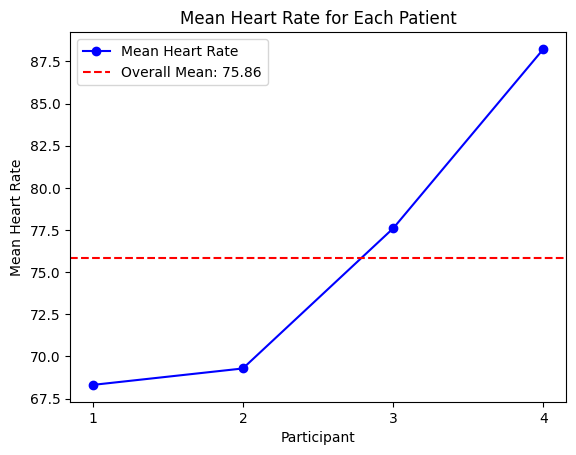

In [45]:
overall_mean_heart_rate = sum(mean_heart_rates) / len(mean_heart_rates)

# Create a line plot for individual mean heart rates
plt.plot(range(1, len(mean_heart_rates) + 1), mean_heart_rates, color='blue', marker='o', linestyle='-', label='Mean Heart Rate')

# Add a horizontal line for the overall mean heart rate
plt.axhline(y=overall_mean_heart_rate, color='red', linestyle='--', label=f'Overall Mean: {overall_mean_heart_rate:.2f}')

# Add labels and title
plt.xlabel('Participant')
plt.ylabel('Mean Heart Rate')
plt.title('Mean Heart Rate for Each Patient')
plt.xticks(range(1, len(mean_heart_rates) + 1))  # Set x-axis ticks to integers

# Add legend
plt.legend()

# Show plot
plt.show()

In [33]:
# HRV mean
mean_hrv = []
for array in all_baseline_arrays:
    signals, info = nk.ecg_process(array, 2000)
    hrv_time = nk.hrv_time(signals, sampling_rate=2000)
    hrv_mean = hrv_time['HRV_MeanNN']
    mean_hrv.append(hrv_mean)
    

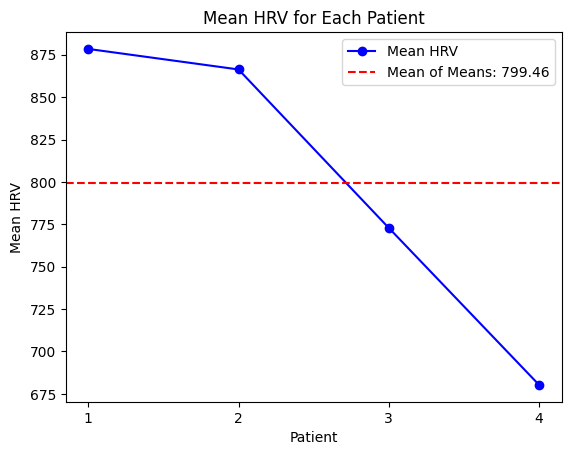

In [42]:
overall_mean_hrv = np.mean(mean_hrv)

# Create a line plot for individual mean HRV values
plt.plot(range(1, len(mean_hrv) + 1), mean_hrv, marker='o', linestyle='-', color='blue', label='Mean HRV')

# Add a horizontal line for the mean of means
plt.axhline(y=overall_mean_hrv, color='red', linestyle='--', label=f'Mean of Means: {overall_mean_hrv:.2f}')

# Add labels and title
plt.xlabel('Patient')
plt.ylabel('Mean HRV')
plt.title('Mean HRV for Each Patient')
plt.xticks(range(1, len(mean_hrv) + 1))  # Set x-axis ticks to integers

# Add legend
plt.legend()

# Show plot
plt.show()

In [34]:
# frequency-domain HRV features
lf_powers = []
hf_powers = []
lf_hf_ratios = []
for array in all_baseline_arrays:
    signals, info = nk.ecg_process(array, 2000)
    hrv_freq = nk.hrv_frequency(signals, sampling_rate=2000)

    lf_power = hrv_freq['HRV_LF']
    lf_powers.append(lf_power)
    hf_power = hrv_freq['HRV_HF']
    hf_powers.append(hf_power)
    lf_hf_ratio = hrv_freq['HRV_LFHF']
    lf_hf_ratios.append(lf_hf_ratio)


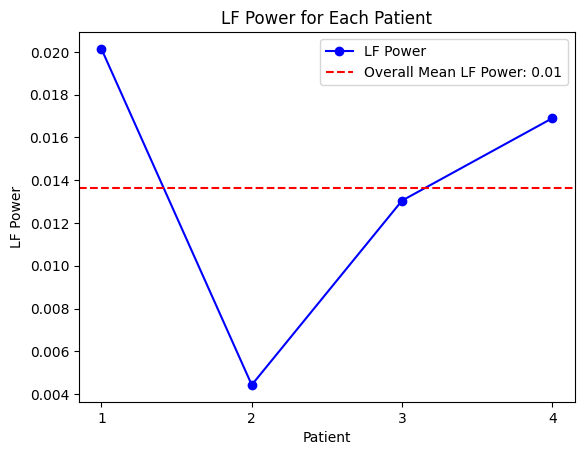

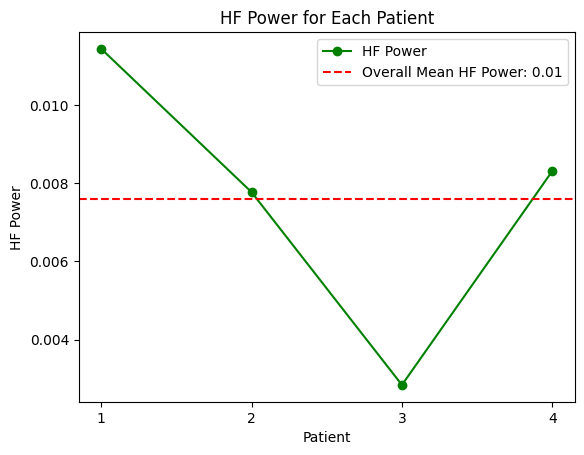

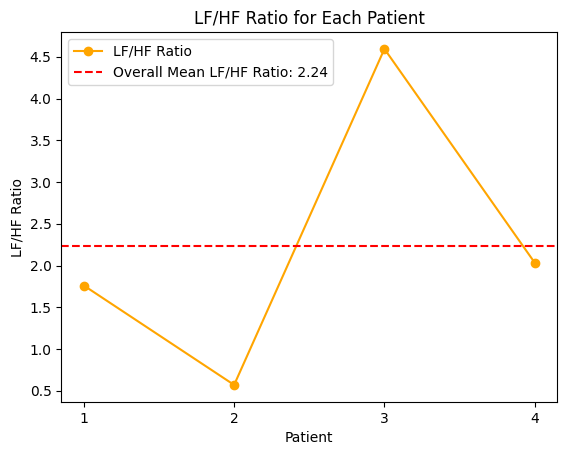

In [41]:
# Calculate overall means for each feature
overall_mean_lf_power = np.mean(lf_powers)
overall_mean_hf_power = np.mean(hf_powers)
overall_mean_lf_hf_ratio = np.mean(lf_hf_ratios)

# Plotting LF Powers
plt.plot(range(1, len(lf_powers) + 1), lf_powers, marker='o', linestyle='-', color='blue', label='LF Power')
plt.axhline(y=overall_mean_lf_power, color='red', linestyle='--', label=f'Overall Mean LF Power: {overall_mean_lf_power:.2f}')
plt.xlabel('Patient')
plt.ylabel('LF Power')
plt.title('LF Power for Each Patient')
plt.xticks(range(1, len(lf_powers) + 1))  # Set x-axis ticks to integers
plt.legend()
plt.show()

# Plotting HF Powers
plt.plot(range(1, len(hf_powers) + 1), hf_powers, marker='o', linestyle='-', color='green', label='HF Power')
plt.axhline(y=overall_mean_hf_power, color='red', linestyle='--', label=f'Overall Mean HF Power: {overall_mean_hf_power:.2f}')
plt.xlabel('Patient')
plt.ylabel('HF Power')
plt.title('HF Power for Each Patient')
plt.xticks(range(1, len(hf_powers) + 1))  # Set x-axis ticks to integers
plt.legend()
plt.show()

# Plotting LF/HF Ratios
plt.plot(range(1, len(lf_hf_ratios) + 1), lf_hf_ratios, marker='o', linestyle='-', color='orange', label='LF/HF Ratio')
plt.axhline(y=overall_mean_lf_hf_ratio, color='red', linestyle='--', label=f'Overall Mean LF/HF Ratio: {overall_mean_lf_hf_ratio:.2f}')
plt.xlabel('Patient')
plt.ylabel('LF/HF Ratio')
plt.title('LF/HF Ratio for Each Patient')
plt.xticks(range(1, len(lf_hf_ratios) + 1))  # Set x-axis ticks to integers
plt.legend()
plt.show()

In [ ]:
ecg_data =  {
    "n_cue": [],
    "n_no_cue": [],
    "p_cue": [],
    "p_no_cue": [],
    "u_cue": [],
    "u_no_cue": []
}
for index, row in df.iterrows():
    value = row['C5 - Expression']
    ecg_value = row['ECG - ECG100C']
    
    
    if value == 020.0:
        ecg_data["n_cue"].append(ecg_value)
    if value == 030.0:
        ecg_data["n_no_cue"].append(ecg_value)
    if value == 120.0:
        ecg_data["p_cue"].append(ecg_value)
    if value == 130.0:
        ecg_data["p_no_cue"].append(ecg_value)
    if value == 220.0:
        ecg_data["u_cue"].append(ecg_value)
    if value == 230.0:
        ecg_data["u_no_cue"].append(ecg_value)
        
max_length = max(len(ecg_data[key]) for key in ecg_data)
for key in ecg_data:
    while len(ecg_data[key]) < max_length:
        ecg_data[key].append(None)
df_ecg = pd.DataFrame(ecg_data)
print(df_ecg)


    
         


In [ ]:


## trying with neurokit   
ecg_sampling_rate = 2000
heart_rate_data = {}
for column in df_ecg.columns:
    signals = nk.ecg_process(df_ecg[column], ecg_sampling_rate)
    heart_rate = nk.ecg_rate(signals)
    heart_rate_data[column] = heart_rate
print("Heart Rates:")
for column, heart_rate in heart_rate_data.items():
    print(f"{column}: {heart_rate.mean()} bpm")

heart_rate_df = pd.DataFrame(heart_rate_data)

mean_heart_rate_per_column = heart_rate_df.mean(axis=0)

print("Mean Heart Rate per column:")
print(mean_heart_rate_per_column)
    
    







    